In [10]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,Lambda
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D,UpSampling2D,Concatenate,Conv2DTranspose
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.callbacks import LearningRateScheduler,Callback
from keras.optimizers import RMSprop
import glob
import cv2
import os
from math import *
from keras.applications.vgg16 import VGG16 
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import h5py
from keras.utils import to_categorical
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from keras.preprocessing.image import ImageDataGenerator
from skimage import measure
from imutils import contours
import imutils
import scipy.misc as sm
import time
from timeit import default_timer as timer

%matplotlib inline

In [11]:
odmodel = load_model('aug_inverter_on_all_imagesx5.h5')

In [12]:
def predictor(full_image_pred,full_image):
    image = full_image_pred
    image[image<190] = 0
    
    cx_cord = []

    blurred = cv2.GaussianBlur(image, (11, 11), 0)
    thresh = cv2.threshold(blurred, 190, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)

    labels = measure.label(thresh, neighbors=8, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")

    for label in np.unique(labels):
        if label == 0:
            continue


        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)

        if numPixels > 150:
            mask = cv2.add(mask, labelMask)


    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    if cnts:
        cnts = contours.sort_contours(cnts)[0]
        
    #image = cv2.imread(image_path)
    image = full_image
    
    for (i, c) in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        ((cX, cY), radius) = cv2.minEnclosingCircle(c)
        
        rect = cv2.fitEllipse(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(image,[box],0,(255,255,0),2)


    plt.imshow(image,vmin = 0, vmax = 255)

    print("Total cars predicted = ", len(cx_cord))
    
    return image

In [13]:
def cropper(x_img,x0,y0):
    x0_end = x0 + 224
    y0_end = y0 + 224
    cropped_img = x_img[x0:x0_end,y0:y0_end]
    
    return cropped_img

In [14]:
def place(prediction,full_image_p,y,x):
    for i in range(224):
        for j in range(224):
            full_image_p[y + i][x + j] = max(full_image_p[y + i][x + j],prediction[0][i][j])


Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars predicted =  0
Total cars p

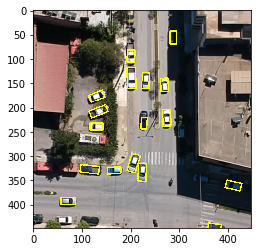

In [17]:
import numpy as np
import cv2

cap = cv2.VideoCapture('videos/video3')
i = 1
max_fps = 0
sum_fps = 0
frame_no = 0
while(cap.isOpened()):
    
    ret, frame = cap.read()
    
    if i%100==0:
        print(i)
    
    if i <0:
        i = i + 1
        continue
    frame_no = frame_no + 1
    start = timer()
    full_image = frame[200:648 ,700:1148]
    #full_image = frame[0:448,0:448]
    full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)
    full_image = np.asarray(full_image)
    full_image_p = np.zeros((448,448))
    for x in range(2):
        for y in range(2):
            img_part = cropper(full_image,y*224,x*224) # overlap = 16 therefore (224 - 16 = 208)
            img_part = np.asarray(img_part)
            img_part = img_part.reshape((1,224,224,3))
            img_part = 255 - img_part
            prediction = odmodel.predict(img_part)
            prediction = np.asarray(prediction)
            prediction = prediction.reshape((1,224,224))
            #print(x," ",y)
            #place(prediction,full_image_p,y*208,x*208)
            full_image_p[y*224:(y+1)*224,x*224:(x+1)*224] = prediction[0]
    bounded_image = predictor(full_image_p,full_image)   
    bounded_image = cv2.cvtColor(bounded_image, cv2.COLOR_BGR2RGB)
    cv2.imshow('frame',bounded_image)
    #print(cap.get(5))
    #end = time.time()
    end = timer() - start
    fps = 1/end
    if fps>max_fps:
        max_fps = fps
    sum_fps = sum_fps + fps
    # print(1/(end - start))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print(max_fps)
print(sum_fps/frame_no)